In [1]:
print("Hello world")

Hello world


In [2]:
import networkx as nx
import numpy as np
from scipy.stats import norm, gaussian_kde
from scipy.integrate import quad
import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [31]:
from scipy.stats import entropy

def kl_divergence(p, q):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Calculez les histogrammes des deux distributions
    bins = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 1000)
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_hist += epsilon
    q_hist += epsilon
    
    # Normalisez les histogrammes
    p_hist /= np.sum(p_hist)
    q_hist /= np.sum(q_hist)
    
    # Calculez la divergence KL
    return entropy(p_hist, q_hist)

from scipy.stats import gaussian_kde

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))



def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))




New model

In [8]:
import jax
print(jax.devices())

[CudaDevice(id=0)]


In [9]:
import sys
print(sys.executable)
print(sys.path)

/usr/bin/python3
['C:\\Program Files\\JetBrains\\PyCharm 2024.1.4\\plugins\\python\\helpers-pro\\jupyter_debug', 'C:\\Program Files\\JetBrains\\PyCharm 2024.1.4\\plugins\\python\\helpers\\pydev', '/root/temp_janis_test_parallellization', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor']


In [10]:
import jax

In [11]:
import numpy as np

In [12]:
import pymc as pm


In [13]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [14]:

# Usage
n_schools = 50
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = load_data_from_json('data/sampled_data.json')


# Convert data to numpy arrays
a = np.array([data[f'a{i}'] for i in range(n_schools)])
c = np.array([data[f'c{i}'] for i in range(n_schools)])
e = np.array([data[f'e{i}'] for i in range(n_schools)])

# For b and d, we need to create 2D arrays
b = np.array([[data[f'_b{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
d = np.array([[data[f'_d{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])

print("Shape of a:", a.shape)
print("Shape of b:", b.shape)
print("Shape of c:", c.shape)
print("Shape of d:", d.shape)
print("Shape of e:", e.shape)
print(data['_b1_2'])
print(b[1, 2])

Data successfully loaded from data/sampled_data.json
Shape of a: (50,)
Shape of b: (50, 50)
Shape of c: (50,)
Shape of d: (50, 50)
Shape of e: (50,)
1.3565596226212755
1.3565596226212755


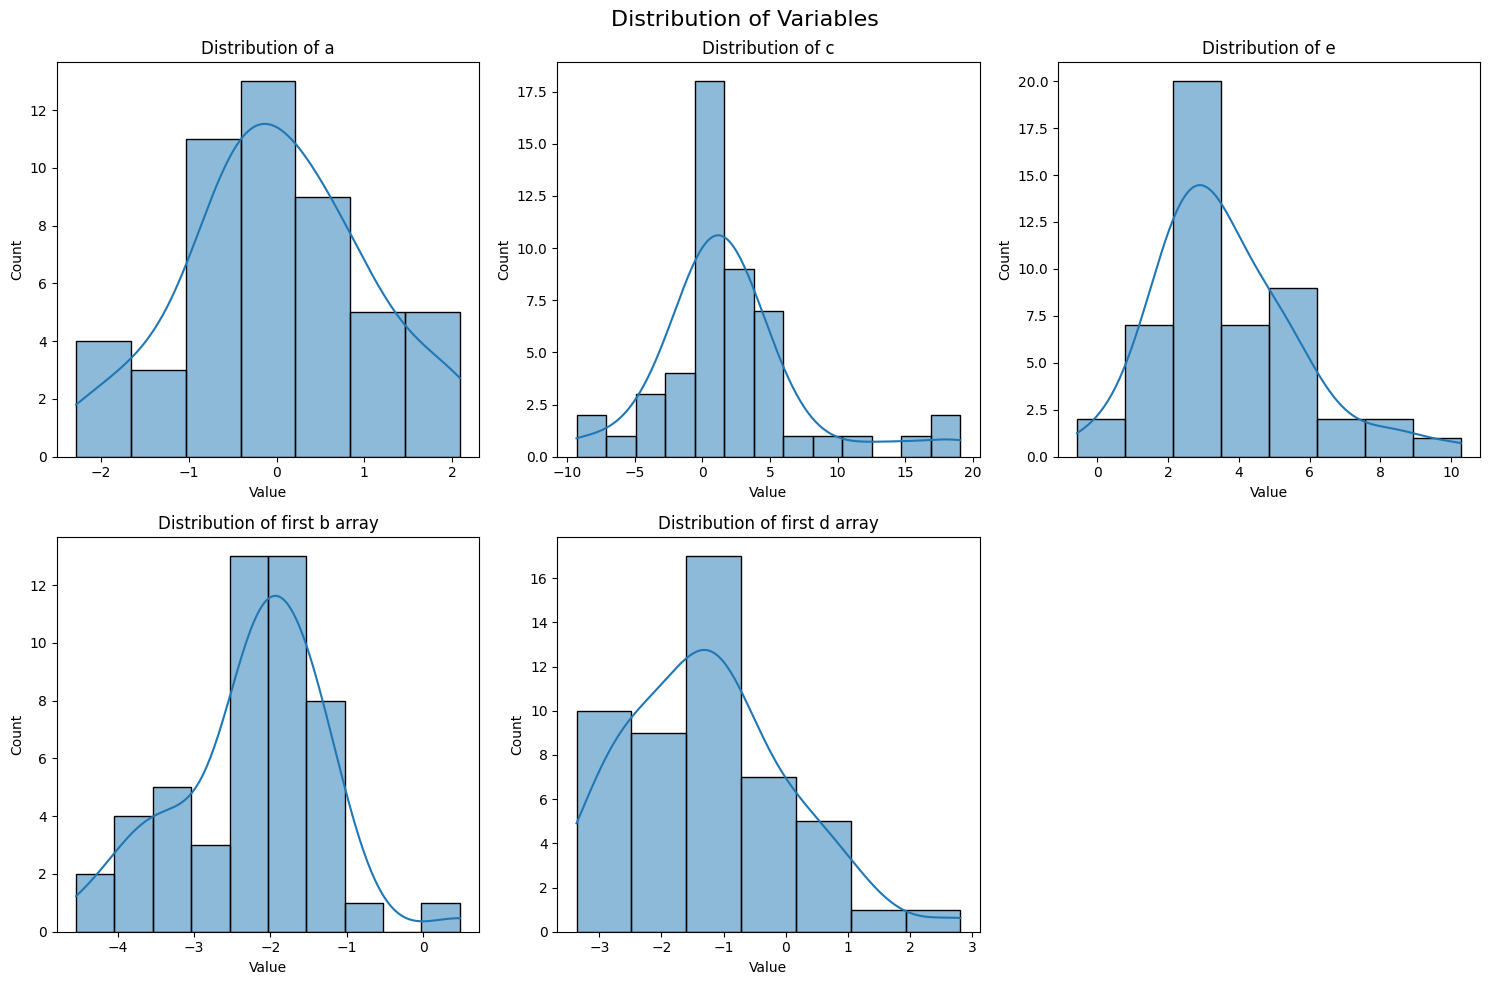

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Variables', fontsize=16)

# Plot distribution of a
sns.histplot(a, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of a')
axes[0, 0].set_xlabel('Value')

# Plot distribution of c
sns.histplot(c, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of c')
axes[0, 1].set_xlabel('Value')

# Plot distribution of e
sns.histplot(e, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of e')
axes[0, 2].set_xlabel('Value')

# Plot distribution of first b array
sns.histplot(b[0], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of first b array')
axes[1, 0].set_xlabel('Value')

# Plot distribution of first d array
sns.histplot(d[0], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of first d array')
axes[1, 1].set_xlabel('Value')

# Remove the unused subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


In [15]:
print(jax.devices())

[CudaDevice(id=0)]


In [26]:
import pymc as pm
import jax
print(jax.devices())
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

[CudaDevice(id=0)]


In [40]:
with pm.Model() as model:
    # Priors pour les coefficients (au niveau des écoles)
    mu_A = pm.Normal('mu_A', mu=0, sigma=1)
    sigma_A = pm.HalfNormal('sigma_A', sigma=1)
    A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)

    mu_C = pm.Normal('mu_C', mu=0, sigma=1)
    sigma_C = pm.HalfNormal('sigma_C', sigma=1)
    C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)

    mu_E = pm.Normal('mu_E', mu=0, sigma=1)
    sigma_E = pm.HalfNormal('sigma_E', sigma=1)
    E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)
    
    
    
    # Variables aléatoires pour les écoles
    alpha_B = pm.Normal('alpha_B', mu=0, sigma=1)
    beta_B_A = pm.Normal('beta_B_A', mu=0, sigma=1)
    beta_B_C = pm.Normal('beta_B_C', mu=0, sigma=1)
    beta_B_E = pm.Normal('beta_B_E', mu=0, sigma=1)
    
    alpha_D = pm.Normal('alpha_D', mu=1, sigma=1)
    beta_D_A = pm.Normal('beta_D_A', mu=1, sigma=1)
    beta_D_C = pm.Normal('beta_D_C', mu=1, sigma=1)
    beta_D_E = pm.Normal('beta_D_E', mu=1, sigma=1)
    beta_D_A3 = pm.Normal('beta_D_A3', mu=1, sigma=1)
    beta_D_A2 = pm.Normal('beta_D_A2', mu=1, sigma=1)


    # Variables aléatoires pour les écoles
    mu_B_j = alpha_B + beta_B_A * a + beta_B_C * c + beta_B_E * e
    mu_D_j = alpha_D + beta_D_A * a + beta_D_C * c + beta_D_E * e + beta_D_A3 * a**3  + beta_D_A2 * a**2
    
    # Ajustement des dimensions pour correspondre à celles des élèves
    mu_B_j = pm.Deterministic('mu_B_j', mu_B_j[:, None])
    mu_D_j = pm.Deterministic('mu_D_j', mu_D_j[:, None])
    
    # Priors pour les écarts types au niveau des élèves
    sigma_B = pm.HalfNormal('sigma_B', sigma=1)
    sigma_D = pm.HalfNormal('sigma_D', sigma=1)
    
    # Niveau des élèves : chaque élève est modelé en fonction de son école
    B = pm.Normal('B', mu=mu_B_j, sigma=sigma_B, observed=b)
    D = pm.Normal('D', mu=mu_D_j, sigma=sigma_D, observed=d)

    # Inference
    trace = pm.sample(1000, return_inferencedata=True, progressbar=True)
    
# Analyse des résultats
print(pm.summary(trace, var_names=['alpha_B', 'beta_B_A', 'beta_B_C', 'beta_B_E','alpha_D', 'beta_D_A', 'beta_D_C', 'beta_D_E',  'sigma_B', 'sigma_D', 'beta_D_A3', 'beta_D_A2', 'mu_A', 'sigma_A', 'mu_C', 'sigma_C', 'mu_E', 'sigma_E', 'mu_B_j', 'mu_D_j']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha_B, beta_B_A, beta_B_C, beta_B_E, alpha_D, beta_D_A, beta_D_C, beta_D_E, beta_D_A3, beta_D_A2, sigma_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_B       -0.037  0.054  -0.139    0.067      0.001    0.001    2766.0   
beta_B_A       0.986  0.045   0.901    1.069      0.001    0.001    2676.0   
beta_B_C      -0.010  0.009  -0.028    0.007      0.000    0.000    2510.0   
beta_B_E       0.021  0.015  -0.008    0.048      0.000    0.000    2806.0   
alpha_D        0.960  0.084   0.807    1.119      0.002    0.001    2238.0   
...              ...    ...     ...      ...        ...      ...       ...   
mu_D_j[45, 0]  0.520  0.075   0.382    0.661      0.001    0.001    2538.0   
mu_D_j[46, 0] -0.209  0.092  -0.379   -0.030      0.002    0.001    2922.0   
mu_D_j[47, 0]  1.597  0.048   1.510    1.687      0.001    0.001    4092.0   
mu_D_j[48, 0]  1.402  0.066   1.275    1.525      0.001    0.001    2657.0   
mu_D_j[49, 0]  0.511  0.058   0.406    0.620      0.001    0.001    3580.0   

               ess_tail  r_hat  
alpha_B          2210.0    1.0

In [41]:
generated_data = {}

# a
mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
generated_data['a'] = new_a

# c
mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
generated_data['c'] = new_c

# e
mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
generated_data['e'] = new_e

# b
mu_B = trace.posterior['mu_B_j'].mean(dim=('chain', 'draw')).values
sigma_B = trace.posterior['sigma_B'].mean(dim=('chain', 'draw')).values
generated_data['b'] = np.random.normal(mu_B, sigma_B)

mu_D = trace.posterior['mu_D_j'].mean(dim=('chain', 'draw')).values
sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values
generated_data['d'] = np.random.normal(mu_D, sigma_D)

# Affichage des formes des données générées
for var in ['a', 'b', 'c', 'd', 'e']:
    print(f"Shape of generated {var}: {generated_data[var].shape}")
    
print("Generated data:", generated_data)


Shape of generated a: (50,)
Shape of generated b: (50, 1)
Shape of generated c: (50,)
Shape of generated d: (50, 1)
Shape of generated e: (50,)
Generated data: {'a': array([ 0.94921891, -0.15060407,  2.44701829, -1.5744978 ,  0.69096593,
       -0.77117357,  0.45138846,  0.17396722, -0.9923396 ,  0.56558768,
       -0.928979  , -0.65704163,  0.39405353,  0.78631165, -0.67505736,
        0.60255643, -2.60839116, -0.10872027, -0.46421891,  0.7595306 ,
        0.06185126, -0.18177456,  0.79989095, -1.1243517 ,  1.28413975,
        0.51367229,  0.68050774,  2.98554561,  1.10063751,  0.09918036,
        0.06759985, -1.13559068,  1.80612522, -0.26415146,  0.78951125,
       -1.29478512, -0.01456304,  0.0214306 ,  0.59603311,  0.6021845 ,
       -0.34867186,  0.76809907, -0.60450543,  0.3263464 , -1.35257876,
       -0.4051136 , -0.17970325,  0.68213362,  0.98979808, -0.62161067]), 'c': array([  2.79718097,   0.11140347,  -1.74691091,  -7.36993989,
         7.79301292,  -0.97248158,   1.21326

In [42]:
# Calcul des divergences KL
kl_divs = {}

for var in ['a', 'b', 'c', 'd', 'e']:
    original = eval(var)  # Les données originales
    generated = generated_data[var]  # Les données générées
    
    # Pour b et d, nous devons aplatir les arrays 2D
    if var in ['b', 'd']:
        original = original.flatten()
        generated = generated.flatten()
    
    kl_divs[var] = kl_divergence(original, generated)

# Affichage des résultats
for var, kl_div in kl_divs.items():
    print(f"KL divergence pour {var}: {kl_div}")

KL divergence pour a: 0.03803025712483777
KL divergence pour b: 1.1643797214634917
KL divergence pour c: 0.07134340888625845
KL divergence pour d: 1.0863716829831274
KL divergence pour e: 0.07959065788841219


/tmp/ipykernel_14441/3110517197.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
/tmp/ipykernel_14441/3110517197.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(generated, ax=ax, color='red', label='Generated', shade=True)
/tmp/ipykernel_14441/3110517197.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
/tmp/ipykernel_14441/3110517197.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your c

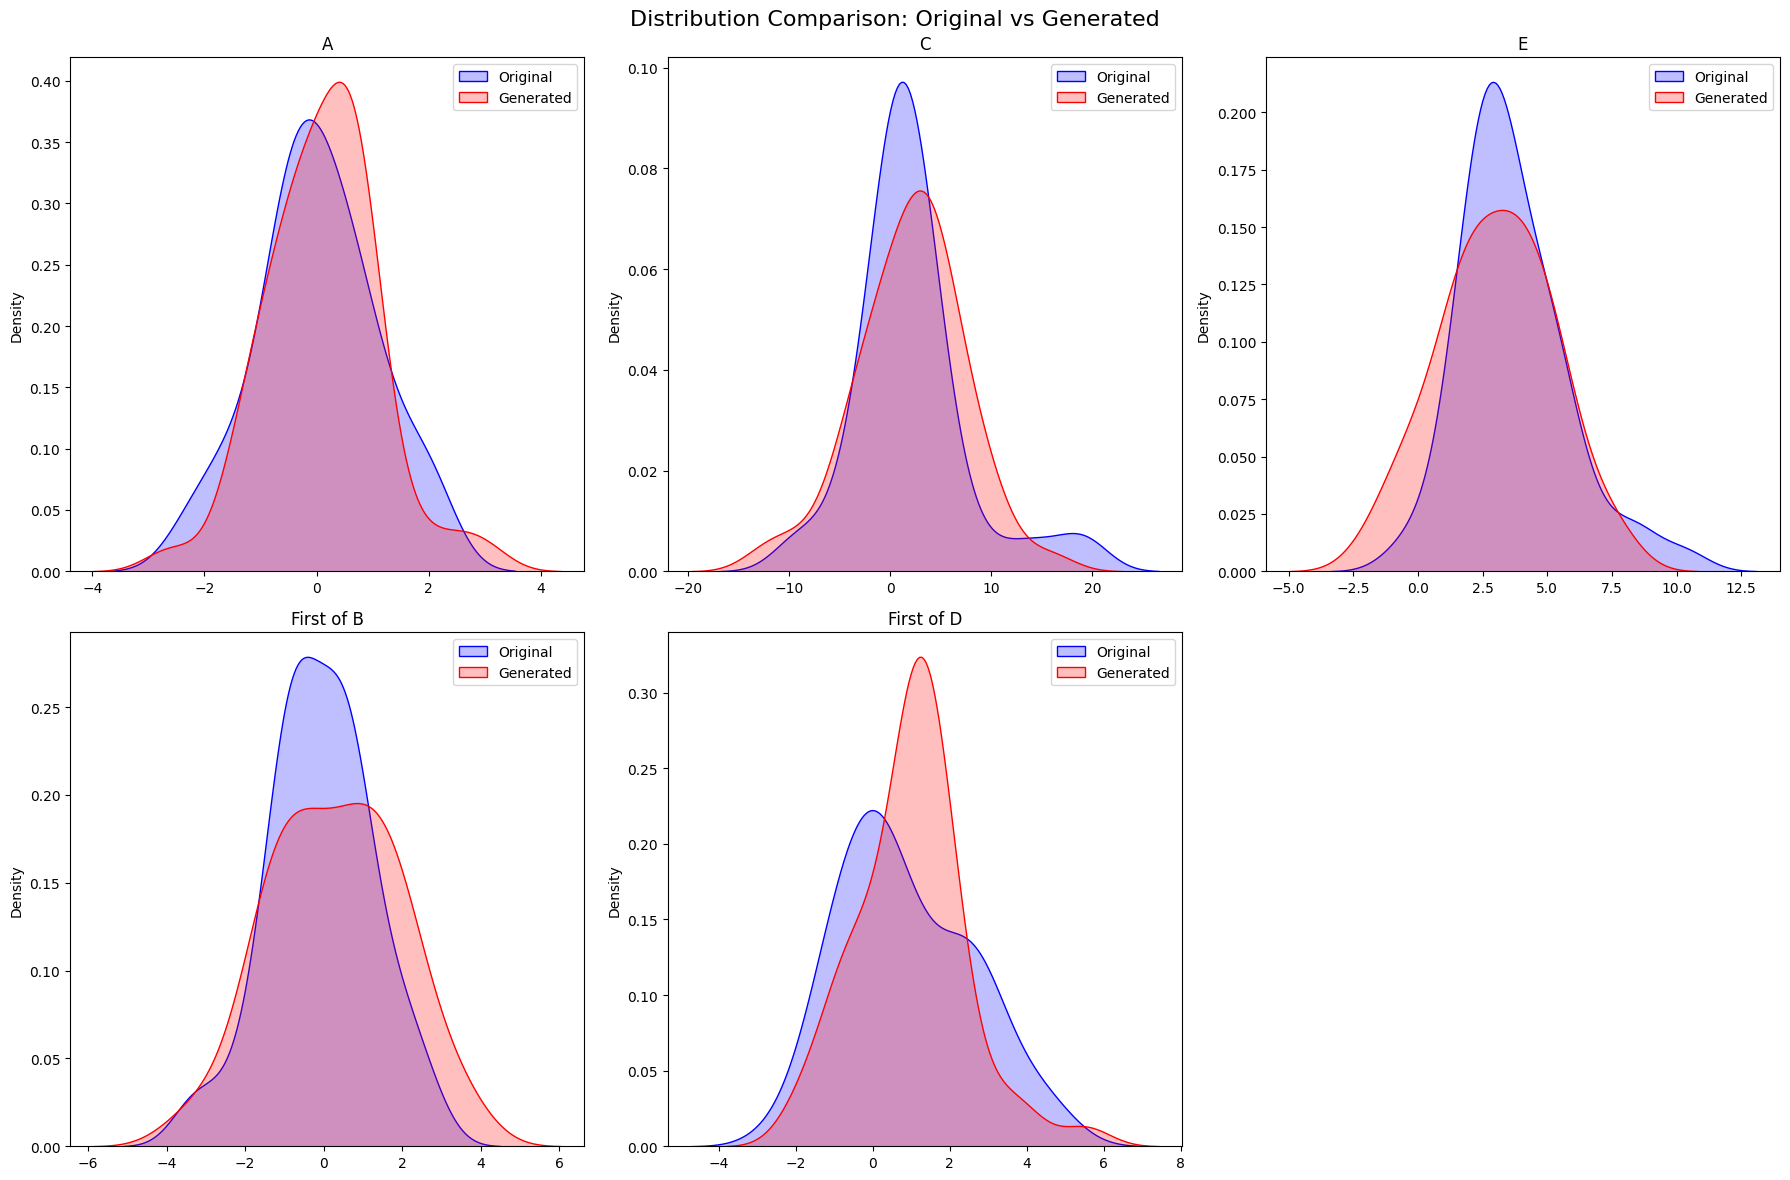

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for A, C, E, first of B, and first of D
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution Comparison: Original vs Generated', fontsize=16)

variables = ['a', 'c', 'e', 'b', 'd']
titles = ['A', 'C', 'E', 'First of B', 'First of D']

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axs[i // 3, i % 3]
    
    # Original data
    if var in ['b', 'd']:
        original = eval(var)[:, 0]  # Take first column for B and D
        generated = generated_data[var][:, 0]
    else:
        original = eval(var)
        generated = generated_data[var]
    
    sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
    sns.kdeplot(generated, ax=ax, color='red', label='Generated', shade=True)
    
    ax.set_title(title)
    ax.legend()

# Remove the empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:

def preprocess_data(self):
    data = {}
    for var in self.unit_vars:
        for i in range(len(self.sizes)):
            data[var + str(i)] = self.data[var + str(i)]
    for var in self.subunit_vars:
        for i in range(len(self.sizes)):
            s = 0
            for j in range(self.sizes[i]):
                s += self.data['_' + var + str(i) + '_' + str(j)]
            data[var + str(i)] = s / self.sizes[i]
    return data


class HierarchicalBayesSampler:
    def __init__(self, graph, data, unit_vars, subunit_vars, sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.unit_vars = unit_vars
        self.subunit_vars = subunit_vars
        self.sizes = sizes
        self.processed_data = self.preprocess_data()

    def preprocess_data(self):
        data = {}
        for var in self.unit_vars:
            for i in range(len(self.sizes)):
                data[var + str(i)] = self.data[var + str(i)]
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                s = 0
                for j in range(self.sizes[i]):
                    s += self.data['_' + var + str(i) + '_' + str(j)]
                data[var + str(i)] = s / self.sizes[i]
        return data

    def generate(self):  # num_samples est maintenant 2
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + self.subunit_vars}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + self.subunit_vars}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # Priors pour les variables de niveau inférieur (sous-unités)
            subunit_variables = {}
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    subunit_variables[f'{var}{i}'] = pm.Normal(f'{var}{i}', mu=mu[var], sigma=sigma[var],
                                                               shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1,
                          observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour les variables de niveau inférieur (sous-unités)
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    pm.Normal(f'obs_{var}{i}',
                              mu=subunit_variables[f'{var}{i}'],
                              sigma=1,
                              observed=np.array([self.data[f'_{var}{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]  # Prend le premier (et seul) échantillon

        # Extraction et génération des sous-unités
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                generated_data[f'{var}{i}'] = trace[f'{var}{i}'][0]  # Prend le premier (et seul) échantillon

        return generated_data

    def generate_cond(self):
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors pour les autres variables
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + ['d']}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + ['d']}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # b est défini comme une variable observée suivant une loi normale standard
            b = pm.Normal('b', mu=0, sigma=1, shape=(len(self.sizes), max(self.sizes)),
                          observed=np.random.normal(0, 1, (len(self.sizes), max(self.sizes))))

            # Priors pour les autres variables de niveau inférieur (d)
            subunit_variables = {}
            for i in range(len(self.sizes)):
                subunit_variables[f'd{i}'] = pm.Normal(f'd{i}', mu=mu['d'], sigma=sigma['d'], shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1,
                          observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour d
            for i in range(len(self.sizes)):
                pm.Normal(f'obs_d{i}',
                          mu=subunit_variables[f'd{i}'],
                          sigma=1,
                          observed=np.array([self.data[f'_d{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]

        # Génération de b (toujours à partir d'une loi normale standard)
        for i in range(len(self.sizes)):
            generated_data[f'b{i}'] = np.random.normal(0, 1, size=self.sizes[i])

        # Extraction de d
        for i in range(len(self.sizes)):
            generated_data[f'd{i}'] = trace[f'd{i}'][0]

        return generated_data


# Usage
n_schools = 50
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]

# Generate data for b and d
for i in range(n_schools):
    for j in range(n_students):
        data[f'_b{i}_{j}'] = 2 * i + j % 2 + 1  # This creates a slight variation between students
        data[f'_d{i}_{j}'] = 2 * i + j % 2 + 7  # This creates a slight variation between students

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

sampling

sampler = HierarchicalBayesSampler(graph, data, unit_vars, subunit_vars, sizes)

generated_data = sampler.generate()
print(generated_data)

generated_data_cond = sampler.generate_cond()
print(generated_data_cond)

In [ ]:
# Compute KL divergence for 'e' variable
e_generated = generated_data['e']
e_original = np.array([sampler.processed_data[f'e{i}'] for i in range(len(sizes))])

e_generated_cond = generated_data_cond['e']

kl_div = kl_divergence(e_original, e_generated)
print(f"KL divergence between original 'e' and generated 'e': {kl_div}")
kl_div_cond = kl_divergence(e_original, e_generated_cond)
print(f"KL divergence between original 'e' and generated 'e' with conditionning: {kl_div_cond}")
